# **Introduction**
## An ECG (Electrocardiogram) measures how your heart’s electrical activity changes during each heartbeat.


# Installing libraries

In [ ]:
!pip install wfdb numpy matplotlib tensorflow scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 151.1 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.3 which is incompatible.
dask-cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.3 which is incompatible.
cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.3 which is incompatible.


In [ ]:
import wfdb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D, Dense, Input, Flatten, Reshape
from tensorflow.keras.optimizers import Adam


# Installing Dataset from PHYSIONET.ORG (MIT-DB)

In [ ]:
!wget -r -N -c -np https://physionet.org/files/mitdb/1.0.0/


Streaming output truncated to the last 5000 lines.
Length: 5468 (5.3K) [application/octet-stream]
Saving to: ‘physionet.org/files/mitdb/1.0.0/223.atr’

physionet.org/files 100%[===================>]   5.34K  --.-KB/s    in 0s      

2025-10-29 05:07:01 (3.05 GB/s) - ‘physionet.org/files/mitdb/1.0.0/223.atr’ saved [5468/5468]

--2025-10-29 05:07:01--  https://physionet.org/files/mitdb/1.0.0/223.dat
Reusing existing connection to physionet.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 1950000 (1.9M) [application/octet-stream]
Saving to: ‘physionet.org/files/mitdb/1.0.0/223.dat’

physionet.org/files 100%[===================>]   1.86M   338KB/s    in 5.5s    

2025-10-29 05:07:07 (346 KB/s) - ‘physionet.org/files/mitdb/1.0.0/223.dat’ saved [1950000/1950000]

--2025-10-29 05:07:07--  https://physionet.org/files/mitdb/1.0.0/223.hea
Reusing existing connection to physionet.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 258 [text/plain]
Saving to: ‘physionet.

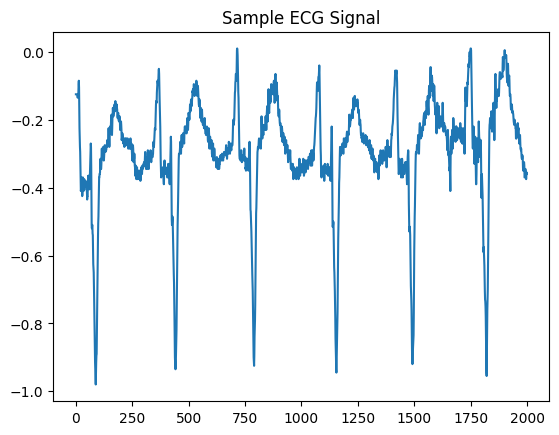

In [ ]:
record = wfdb.rdrecord('physionet.org/files/mitdb/1.0.0/108')
annotation = wfdb.rdann('physionet.org/files/mitdb/1.0.0/108', 'atr')
signal = record.p_signal[:,0]  # one channel
plt.plot(signal[:2000])
plt.title("Sample ECG Signal")
plt.show()


In [ ]:
# Load one full ECG record
record = wfdb.rdrecord('213', pn_dir='mitdb')
annotation = wfdb.rdann('213', 'atr', pn_dir='mitdb')

signal = record.p_signal[:, 0]  # first ECG lead
print("Signal length:", len(signal))

Signal length: 650000


In [ ]:
window_size = 200  # samples per segment
X, y = [], []

for i, sym in enumerate(annotation.symbol):
    start = annotation.sample[i]
    end = start + window_size
    if end < len(signal):
        segment = signal[start:end]
        label = 0 if sym == 'N' else 1
        X.append(segment)
        y.append(label)

X = np.array(X)
y = np.array(y)

print("X shape:", X.shape)
print("y distribution:", np.unique(y, return_counts=True))


X shape: (3293, 200)
y distribution: (array([0, 1]), array([2640,  653]))


In [ ]:

X_flat = X.reshape(X.shape[0], -1)
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_flat, y)
print("After SMOTE:", Counter(y_res))

After SMOTE: Counter({np.int64(1): 2640, np.int64(0): 2640})


In [ ]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res, test_size=0.2, random_state=42, stratify=y_res)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# reshape for CNN
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)


# Model

In [ ]:

# 🧠 Balanced CNN Model (simpler and more stable)

model = Sequential([
    Conv1D(32, 3, activation='relu', input_shape=(200, 1)),
    MaxPooling1D(2),
    Dropout(0.2),
    Conv1D(64, 3, activation='relu'),
    MaxPooling1D(2),
    Dropout(0.2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_14 (Conv1D)              │ (None, 198, 32)        │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_8 (MaxPooling1D)  │ (None, 99, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 99, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_15 (Conv1D)              │ (None, 97, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_9 (MaxPooling1D)  │ (None, 48, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 48, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │       196,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 203,073 (793.25 KB)

 Trainable params: 203,073 (793.25 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:

# 🚀 Train the Model (no class weights; SMOTE already used)

history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)


Epoch 1/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.8269 - loss: 0.3865 - val_accuracy: 0.9408 - val_loss: 0.1883
Epoch 2/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9339 - loss: 0.1916 - val_accuracy: 0.9349 - val_loss: 0.1842
Epoch 3/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9545 - loss: 0.1381 - val_accuracy: 0.9586 - val_loss: 0.1448
Epoch 4/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9563 - loss: 0.1389 - val_accuracy: 0.9527 - val_loss: 0.1417
Epoch 5/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9657 - loss: 0.1098 - val_accuracy: 0.9586 - val_loss: 0.1267
Epoch 6/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9644 - loss: 0.1001 - val_accuracy: 0.9621 - val_loss: 0.1239
Epoch 7/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9641 - loss: 0.1003 - val_accuracy: 0.9609 - val_loss: 0.1194
Epoch 8/10
106/106 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9666 - loss: 0.0975 - val_accu

In [ ]:

# 🧪 Evaluate Model

loss, acc = model.evaluate(X_test, y_test)
print(f"✅ Test Accuracy: {acc*100:.2f}%")


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9664 - loss: 0.0956
✅ Test Accuracy: 96.69%


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
              precision    recall  f1-score   support

      Normal       0.97      0.97      0.97       528
    Abnormal       0.97      0.97      0.97       528

    accuracy                           0.97      1056
   macro avg       0.97      0.97      0.97      1056
weighted avg       0.97      0.97      0.97      1056



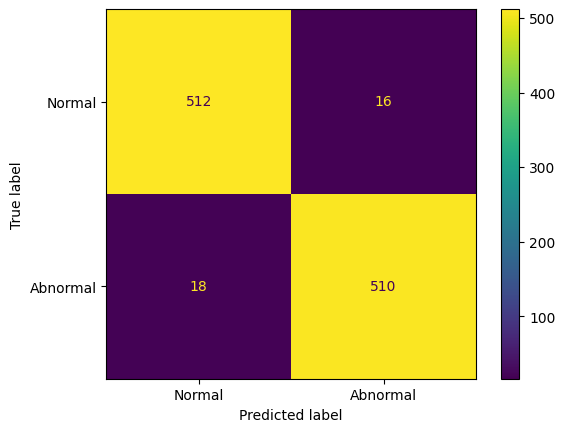

In [ ]:

# 📊 Classification Report

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

y_prob = model.predict(X_test)
y_pred = (y_prob > 0.45).astype(int)

print(classification_report(y_test, y_pred, target_names=["Normal", "Abnormal"]))
ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred),
                       display_labels=["Normal", "Abnormal"]).plot()
plt.show()

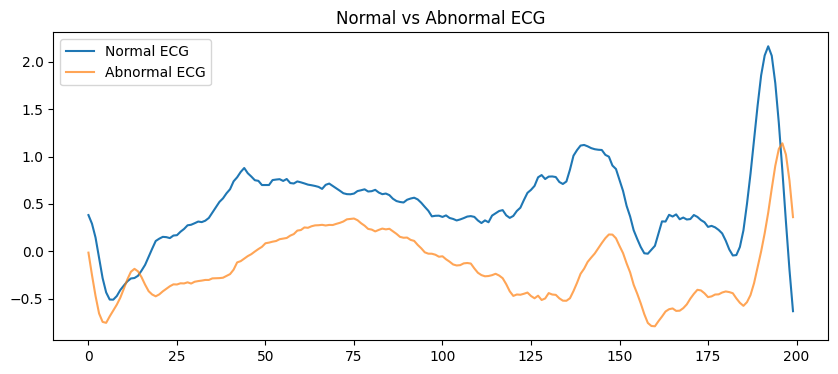

In [ ]:

# 🩻 Visual Example: Normal vs Abnormal

normal_ex = X_train[y_train == 0][0].flatten()
abnormal_ex = X_train[y_train == 1][0].flatten()

plt.figure(figsize=(10,4))
plt.plot(normal_ex, label="Normal ECG")
plt.plot(abnormal_ex, label="Abnormal ECG", alpha=0.7)
plt.legend()
plt.title("Normal vs Abnormal ECG")
plt.show()

In [ ]:

#  Autoencoder (for Explainability)

X_train_normals = X_train[y_train == 0]
input_ecg = Input(shape=(200, 1))
x = Conv1D(16, 3, activation='relu', padding='same')(input_ecg)
x = MaxPooling1D(2, padding='same')(x)
x = Conv1D(8, 3, activation='relu', padding='same')(x)
encoded = MaxPooling1D(2, padding='same')(x)

x = Conv1D(8, 3, activation='relu', padding='same')(encoded)
x = UpSampling1D(2)(x)
x = Conv1D(16, 3, activation='relu', padding='same')(x)
x = UpSampling1D(2)(x)
decoded = Conv1D(1, 3, activation='linear', padding='same')(x)

autoencoder = Model(input_ecg, decoded)
autoencoder.compile(optimizer=Adam(0.001), loss='mse')
autoencoder.fit(X_train_normals, X_train_normals, epochs=10, batch_size=32, validation_split=0.1)


Epoch 1/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.4773 - val_loss: 0.0364
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0252 - val_loss: 0.0118
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0099 - val_loss: 0.0081
Epoch 4/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0076 - val_loss: 0.0064
Epoch 5/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0059 - val_loss: 0.0054
Epoch 6/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0051 - val_loss: 0.0047
Epoch 7/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0042 - val_loss: 0.0040
Epoch 8/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0039 - val_loss: 0.0033
Epoch 9/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0032 - val_loss: 0.0023
Epoch 10/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0022 - val_loss: 0.0020


In [ ]:
loss, acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {acc*100:.2f}%")


33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9664 - loss: 0.0956
Test Accuracy: 96.69%


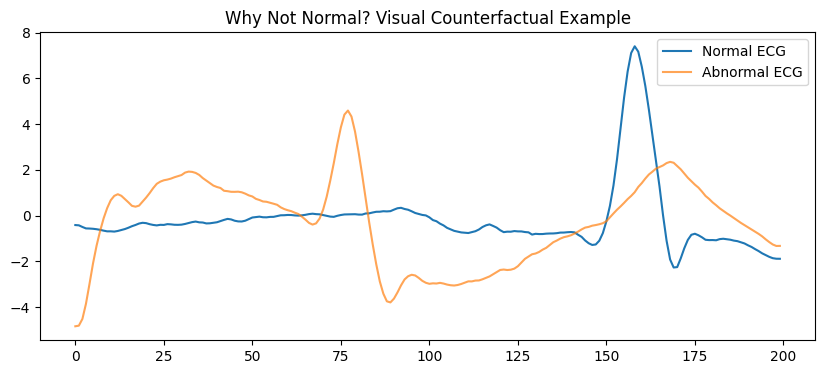

In [ ]:
import matplotlib.pyplot as plt

# Example: one abnormal vs one normal ECG window
normal_ex = X_scaled[y == 0][0].flatten()
abnormal_ex = X_scaled[y == 1][0].flatten()

plt.figure(figsize=(10,4))
plt.plot(normal_ex, label="Normal ECG")
plt.plot(abnormal_ex, label="Abnormal ECG", alpha=0.7)
plt.legend()
plt.title("Why Not Normal? Visual Counterfactual Example")
plt.show()


This plot visually explains why an ECG was classified as abnormal by comparing it to what a normal ECG would look like under similar conditions.

# XAI

In [ ]:
# Only run if not already installed
!pip install scipy matplotlib

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, peak_widths
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, UpSampling1D
from tensorflow.keras.optimizers import Adam


In [ ]:
# get sampling frequency from record (MIT-BIH uses 360 Hz usually)
fs = int(record.fs) if hasattr(record, 'fs') else 360
print("Sampling rate (Hz):", fs)

# Prepare normal-only training data (from X_train)
X_train = np.array(X_train)  # ensure numpy
y_train = np.array(y_train)

X_train_normals = X_train[y_train == 0]
print("Normal training samples:", X_train_normals.shape)

# Autoencoder architecture (simple, small)
win_len = X_train_normals.shape[1]  # e.g., 200

input_ecg = Input(shape=(win_len, 1))
x = Conv1D(16, 3, activation='relu', padding='same')(input_ecg)
x = MaxPooling1D(2, padding='same')(x)
x = Conv1D(8, 3, activation='relu', padding='same')(x)
encoded = MaxPooling1D(2, padding='same')(x)

x = Conv1D(8, 3, activation='relu', padding='same')(encoded)
x = UpSampling1D(2)(x)
x = Conv1D(16, 3, activation='relu', padding='same')(x)
x = UpSampling1D(2)(x)
decoded = Conv1D(1, 3, activation='linear', padding='same')(x)

autoencoder = Model(input_ecg, decoded)
autoencoder.compile(optimizer=Adam(0.001), loss='mse')
autoencoder.summary()

# Train (keep epochs small so it runs fast; increase if you have time)
history_ae = autoencoder.fit(X_train_normals, X_train_normals,
                             epochs=10, batch_size=32, validation_split=0.1)


Sampling rate (Hz): 360
Normal training samples: (2112, 200, 1)


Model: "functional_38"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 200, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_21 (Conv1D)              │ (None, 200, 16)        │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_12 (MaxPooling1D) │ (None, 100, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_22 (Conv1D)              │ (None, 100, 8)         │           392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_13 (MaxPooling1D) │ (None, 50, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_23 (Conv1D)              │ (None, 50, 8)          │           200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_6 (UpSampling1D)  │ (None, 100, 8)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_24 (Conv1D)              │ (None, 100, 16)        │           400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling1d_7 (UpSampling1D)  │ (None, 200, 16)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_25 (Conv1D)              │ (None, 200, 1)         │            49 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,105 (4.32 KB)

 Trainable params: 1,105 (4.32 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.4107 - val_loss: 0.0338
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0253 - val_loss: 0.0095
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0084 - val_loss: 0.0064
Epoch 4/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0055 - val_loss: 0.0049
Epoch 5/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0046 - val_loss: 0.0041
Epoch 6/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0037 - val_loss: 0.0035
Epoch 7/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0031 - val_loss: 0.0031
Epoch 8/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0029 - val_loss: 0.0028
Epoch 9/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0026 - val_loss: 0.0025
Epoch 10/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0023 - val_loss: 0.0023


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step


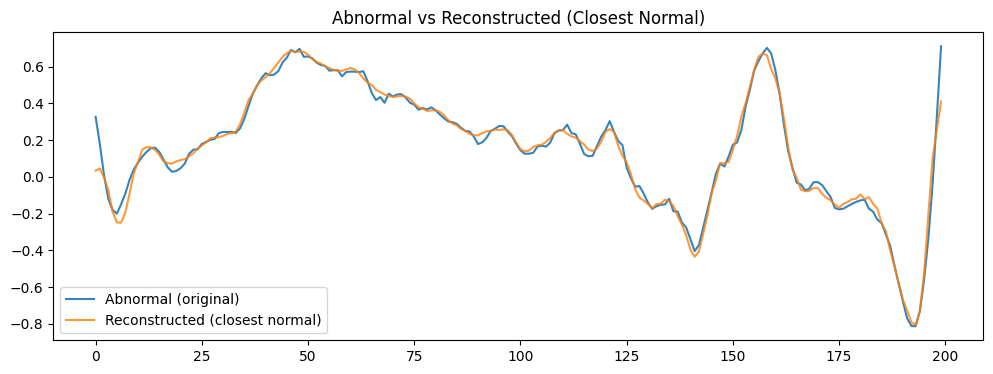

In [ ]:
# Helper to pick one abnormal example from test set
X_test = np.array(X_test)
y_test = np.array(y_test)

# choose first abnormal in test set (or index you like)
ab_idx = np.where(y_test == 1)[0]
if len(ab_idx) == 0:
    raise RuntimeError("No abnormal samples in X_test. Try using another record or reduce split randomness.")
i = ab_idx[0]
ab_sample = X_test[i:i+1]  # shape (1, win_len, 1)

recon = autoencoder.predict(ab_sample)

plt.figure(figsize=(12,4))
plt.plot(ab_sample.flatten(), label='Abnormal (original)', alpha=0.9)
plt.plot(recon.flatten(), label='Reconstructed (closest normal)', alpha=0.8)
plt.legend()
plt.title("Abnormal vs Reconstructed (Closest Normal)")
plt.show()


In [ ]:
def compute_basic_diff_metrics(orig, recon, fs):
    # orig, recon: 1D arrays (unscaled or scaled — both fine relatively)
    orig = orig.flatten()
    recon = recon.flatten()
    diff = orig - recon

    l2 = np.linalg.norm(diff)
    mean_abs = np.mean(np.abs(diff))

    # Peak detection (R-peaks) - tune height and distance if needed
    # We use simple find_peaks on the signal; depending on scaling you may adjust 'height' or 'prominence'
    peaks_o, _ = find_peaks(orig, distance=int(0.2*fs), prominence=0.3)   # at least 200ms apart
    peaks_r, _ = find_peaks(recon, distance=int(0.2*fs), prominence=0.3)

    # Basic heart-rate-like measure in this window
    duration_sec = len(orig) / fs
    hr_o = len(peaks_o) * (60.0 / duration_sec)   # bpm approximation in this window
    hr_r = len(peaks_r) * (60.0 / duration_sec)

    # amplitude of largest peak
    amp_o = orig[peaks_o].mean() if len(peaks_o)>0 else np.nan
    amp_r = recon[peaks_r].mean() if len(peaks_r)>0 else np.nan

    # compute average RR interval in ms if possible
    rr_o = np.diff(peaks_o) / fs * 1000 if len(peaks_o) > 1 else np.array([])
    rr_r = np.diff(peaks_r) / fs * 1000 if len(peaks_r) > 1 else np.array([])

    mean_rr_o = rr_o.mean() if len(rr_o)>0 else np.nan
    mean_rr_r = rr_r.mean() if len(rr_r)>0 else np.nan

    return {
        'l2': float(l2),
        'mean_abs': float(mean_abs),
        'num_peaks_orig': int(len(peaks_o)),
        'num_peaks_recon': int(len(peaks_r)),
        'hr_orig_bpm': float(hr_o) if not np.isnan(hr_o) else None,
        'hr_recon_bpm': float(hr_r) if not np.isnan(hr_r) else None,
        'mean_peak_amp_orig': float(amp_o) if not np.isnan(amp_o) else None,
        'mean_peak_amp_recon': float(amp_r) if not np.isnan(amp_r) else None,
        'mean_rr_orig_ms': float(mean_rr_o) if not np.isnan(mean_rr_o) else None,
        'mean_rr_recon_ms': float(mean_rr_r) if not np.isnan(mean_rr_r) else None
    }

metrics = compute_basic_diff_metrics(ab_sample.flatten(), recon.flatten(), fs)
metrics


{'l2': 0.6269470794000606,
 'mean_abs': 0.026332788494604853,
 'num_peaks_orig': 2,
 'num_peaks_recon': 2,
 'hr_orig_bpm': 216.0,
 'hr_recon_bpm': 216.0,
 'mean_peak_amp_orig': 0.6989488228076406,
 'mean_peak_amp_recon': 0.6777584552764893,
 'mean_rr_orig_ms': 305.5555555555556,
 'mean_rr_recon_ms': 308.33333333333337}

In [ ]:
def generate_text_explanation(metrics, threshold_mean_abs=0.05, threshold_hr_diff=10):
    lines = []
    # 1. Mean absolute difference
    if metrics['mean_abs'] > threshold_mean_abs:
        lines.append("Overall waveform shape and amplitude differ noticeably from normal.")
    else:
        lines.append("Overall waveform is similar to normal in amplitude and shape.")
    # 2. Heart rate / peak count differences
    if metrics['hr_orig_bpm'] is not None and metrics['hr_recon_bpm'] is not None:
        hr_diff = metrics['hr_orig_bpm'] - metrics['hr_recon_bpm']
        if abs(hr_diff) > threshold_hr_diff:
            if hr_diff > 0:
                lines.append(f"Higher estimated heart rate in abnormal ECG (~{metrics['hr_orig_bpm']:.0f} bpm) vs reconstructed (~{metrics['hr_recon_bpm']:.0f} bpm).")
            else:
                lines.append(f"Lower estimated heart rate in abnormal ECG (~{metrics['hr_orig_bpm']:.0f} bpm) vs reconstructed (~{metrics['hr_recon_bpm']:.0f} bpm).")
        else:
            lines.append(f"Heart rate similar between abnormal and reconstructed (~{metrics['hr_orig_bpm']:.0f} bpm).")
    # 3. Peak amplitude
    if metrics['mean_peak_amp_orig'] is not None and metrics['mean_peak_amp_recon'] is not None:
        amp_diff = metrics['mean_peak_amp_orig'] - metrics['mean_peak_amp_recon']
        if abs(amp_diff) > 0.2 * (abs(metrics['mean_peak_amp_recon']) + 1e-6):  # relative change threshold
            lines.append("Peak amplitude differs substantially between abnormal and normal.")
    # 4. RR intervals
    if metrics['mean_rr_orig_ms'] is not None and metrics['mean_rr_recon_ms'] is not None:
        rr_diff = metrics['mean_rr_orig_ms'] - metrics['mean_rr_recon_ms']
        if abs(rr_diff) > 50:  # 50 ms difference threshold (tunable)
            lines.append(f"The average RR interval differs (~{metrics['mean_rr_orig_ms']:.0f} ms vs {metrics['mean_rr_recon_ms']:.0f} ms).")
    # final short summary
    if len(lines) == 0:
        lines.append("No significant differences detected by simple metrics.")
    return " ".join(lines)

explanation_text = generate_text_explanation(metrics)
print("Generated explanation:\n", explanation_text)


Generated explanation:
 Overall waveform is similar to normal in amplitude and shape. Heart rate similar between abnormal and reconstructed (~216 bpm).


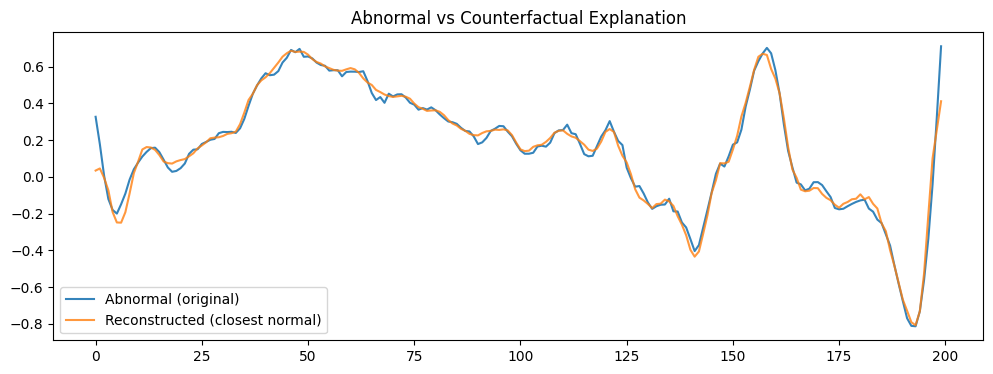

=== Numeric metrics ===
l2: 0.6269470794000606
mean_abs: 0.026332788494604853
num_peaks_orig: 2
num_peaks_recon: 2
hr_orig_bpm: 216.0
hr_recon_bpm: 216.0
mean_peak_amp_orig: 0.6989488228076406
mean_peak_amp_recon: 0.6777584552764893
mean_rr_orig_ms: 305.5555555555556
mean_rr_recon_ms: 308.33333333333337

=== Text explanation ===
Overall waveform is similar to normal in amplitude and shape. Heart rate similar between abnormal and reconstructed (~216 bpm).


In [ ]:
def explain_one_sample(orig_sample, recon_sample, fs, title="Sample Explanation"):
    # plot
    plt.figure(figsize=(12,4))
    plt.plot(orig_sample.flatten(), label='Abnormal (original)', alpha=0.9)
    plt.plot(recon_sample.flatten(), label='Reconstructed (closest normal)', alpha=0.8)
    plt.legend()
    plt.title(title)
    plt.show()

    # metrics + text
    m = compute_basic_diff_metrics(orig_sample.flatten(), recon_sample.flatten(), fs)
    txt = generate_text_explanation(m)
    print("=== Numeric metrics ===")
    for k,v in m.items():
        print(f"{k}: {v}")
    print("\n=== Text explanation ===")
    print(txt)

# Use it on the sample we reconstructed earlier
explain_one_sample(ab_sample, recon, fs, title="Abnormal vs Counterfactual Explanation")


The blue line represents the original abnormal ECG (the real, possibly irregular heart signal).

The orange line shows the reconstructed version, i.e., the model’s attempt to transform or approximate it into the closest normal ECG.

The model understands what a normal heartbeat looks like and can show how far the abnormal one deviates.

Running SHAP DeepExplainer on ECG CNN...


/usr/local/lib/python3.12/dist-packages/shap/explainers/_deep/deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_182
Received: inputs=['Tensor(shape=(30, 200, 1))']
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_182
Received: inputs=['Tensor(shape=(60, 200, 1))']
  warnings.warn(msg)


SHAP values shape: (200, 1)
Input shape: (50, 200)


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_182
Received: inputs=['Tensor(shape=(50, 200, 1))']
  warnings.warn(msg)


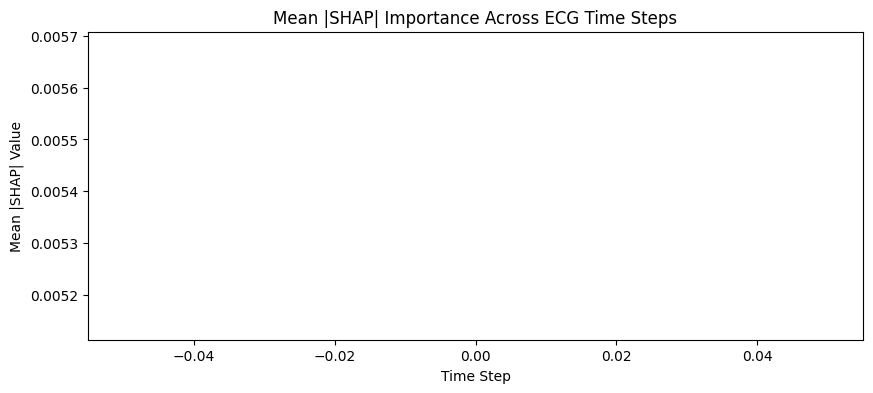

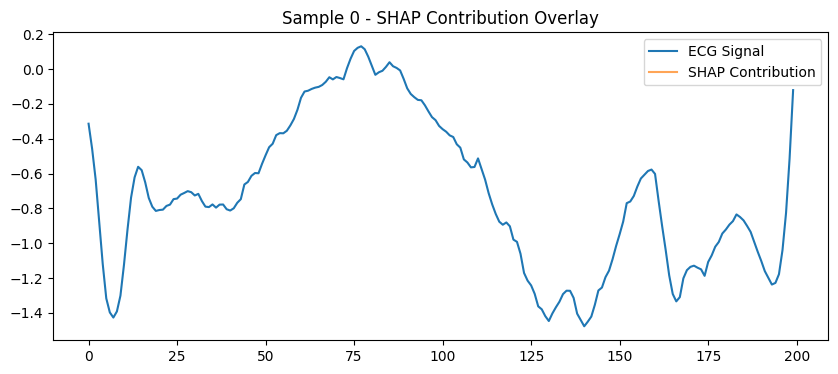


================ ECG MODEL REPORT ================
Test Accuracy: 96.69%
Autoencoder Difference Metrics:
l2: 0.6269470794000606
mean_abs: 0.026332788494604853
num_peaks_orig: 2
num_peaks_recon: 2
hr_orig_bpm: 216.0
hr_recon_bpm: 216.0
mean_peak_amp_orig: 0.6989488228076406
mean_peak_amp_recon: 0.6777584552764893
mean_rr_orig_ms: 305.5555555555556
mean_rr_recon_ms: 308.33333333333337

Explanation Summary:
Overall waveform is similar to normal in amplitude and shape. Heart rate similar between abnormal and reconstructed (~216 bpm).



In [ ]:

# 🧠 EXTRA EXPLAINABILITY & MODEL SAVING

!pip install shap joblib

import shap
import joblib
import pandas as pd

# ======================
# ✅ FIXED SHAP EXPLAINABILITY FOR 1D CNN

!pip install shap joblib

import shap
import joblib
import numpy as np
import matplotlib.pyplot as plt

# Use a smaller subset for quick explainability
explainer_sample = X_test[:50]
background = X_train[np.random.choice(X_train.shape[0], 30, replace=False)]

print("Running SHAP DeepExplainer on ECG CNN...")

# Initialize SHAP DeepExplainer
explainer = shap.DeepExplainer(model, background)
shap_values = explainer.shap_values(explainer_sample)

# shap_values is a list [array(batch, time_steps, channels)]
# We'll flatten it for visualization
sv = shap_values[0].mean(axis=2)  # average over channel dimension if it's (n, t, 1)
X_flat = explainer_sample.squeeze()  # (n, t)

# Sanity check
print("SHAP values shape:", sv.shape)
print("Input shape:", X_flat.shape)

# Plot mean SHAP importance across ECG time steps
plt.figure(figsize=(10,4))
plt.plot(np.mean(np.abs(sv), axis=0))
plt.title("Mean |SHAP| Importance Across ECG Time Steps")
plt.xlabel("Time Step")
plt.ylabel("Mean |SHAP| Value")
plt.show()

# Optional: show sample-level explanation
sample_idx = 0
plt.figure(figsize=(10,4))
plt.plot(X_flat[sample_idx], label="ECG Signal")
plt.plot(sv[sample_idx], label="SHAP Contribution", alpha=0.7)
plt.legend()
plt.title(f"Sample {sample_idx} - SHAP Contribution Overlay")
plt.show()


# 2️⃣ GENERATE EXPLAINABILITY REPORT


def generate_ecg_report(model, history, test_acc, metrics, explanation_text):
    """Generate a summary dataframe + printout report for the ECG model"""
    print("\n================ ECG MODEL REPORT ================")
    print(f"Test Accuracy: {test_acc*100:.2f}%")
    print("Autoencoder Difference Metrics:")
    for k, v in metrics.items():
        print(f"{k}: {v}")
    print("\nExplanation Summary:")
    print(explanation_text)
    print("==================================================\n")

    # Create structured report
    report = {
        "Test_Accuracy": [test_acc],
        "L2_Diff": [metrics['l2']],
        "Mean_Abs_Diff": [metrics['mean_abs']],
        "HR_Orig_BPM": [metrics['hr_orig_bpm']],
        "HR_Recon_BPM": [metrics['hr_recon_bpm']],
        "RR_Orig_ms": [metrics['mean_rr_orig_ms']],
        "RR_Recon_ms": [metrics['mean_rr_recon_ms']],
        "Explanation": [explanation_text]
    }

    df_report = pd.DataFrame(report)


generate_ecg_report(model, history, acc, metrics, explanation_text)




In [ ]:

# 3️⃣ SAVE MODEL + SCALER FOR STREAMLIT


# Save model
model.save("ecg_cnn_model.keras")

# Save scaler
joblib.dump(scaler, "scaler.pkl")

# Save class names or metadata if needed
class_names = ["Normal", "Abnormal"]
joblib.dump(class_names, "class_names.pkl")

print("✅ Model, Scaler, and Metadata saved for Streamlit integration!")

# (Optional) Create a ZIP for easy download
import zipfile

with zipfile.ZipFile("ecg_model_bundle.zip", "w") as zipf:
    zipf.write("ecg_cnn_model.keras")
    zipf.write("scaler.pkl")
    zipf.write("class_names.pkl")
    # zipf.write("ecg_explainability_report.csv") # Report is not saved to file

print("📦 ecg_model_bundle.zip ready for download")

✅ Model, Scaler, and Metadata saved for Streamlit integration!
📦 ecg_model_bundle.zip ready for download


✅ Model and scaler loaded successfully.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


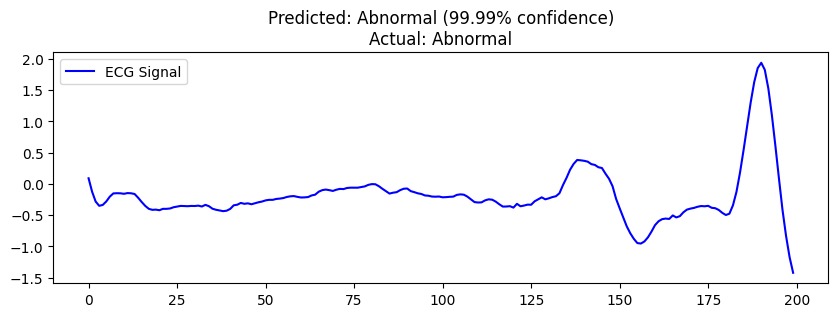

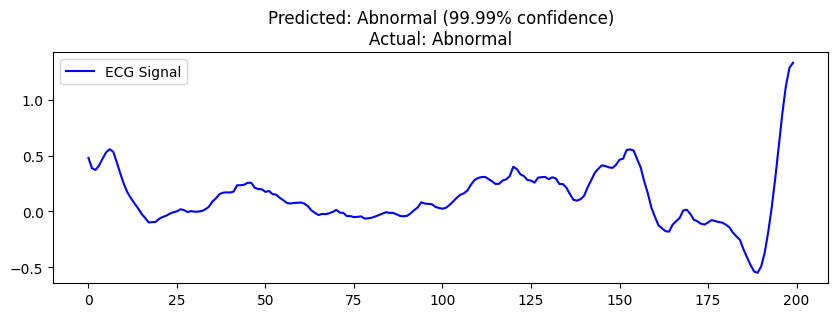

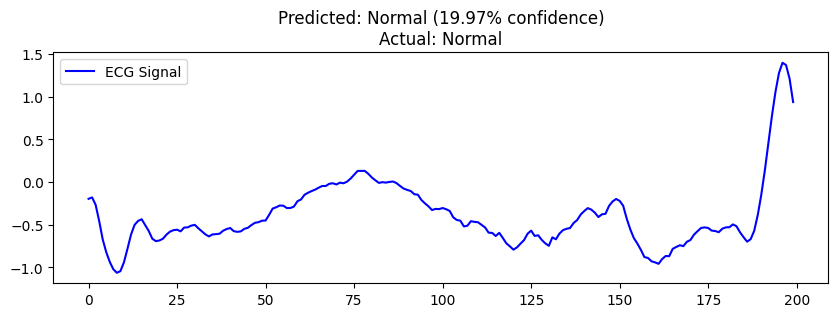

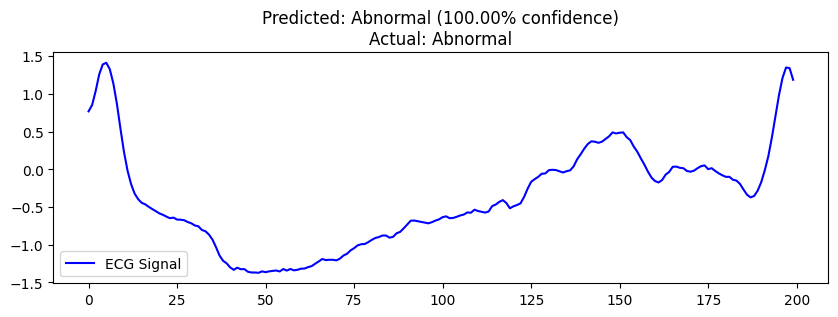

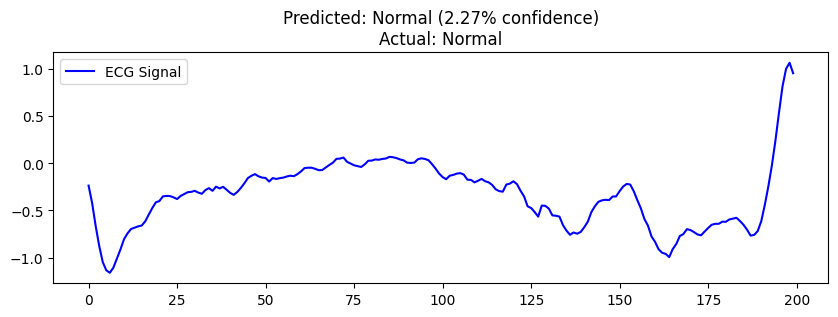

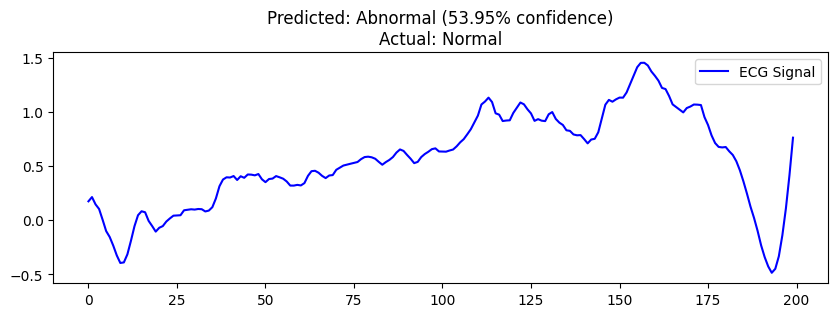

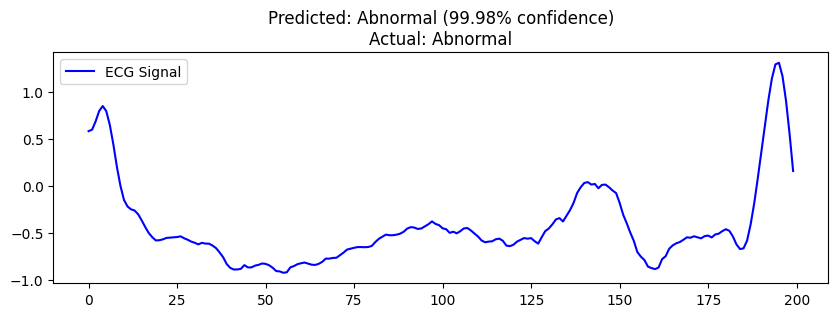

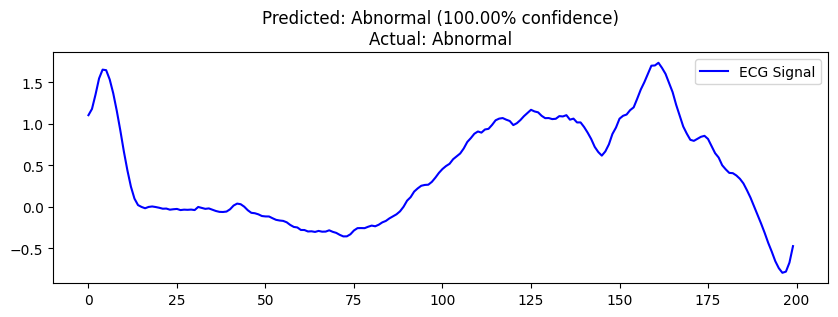

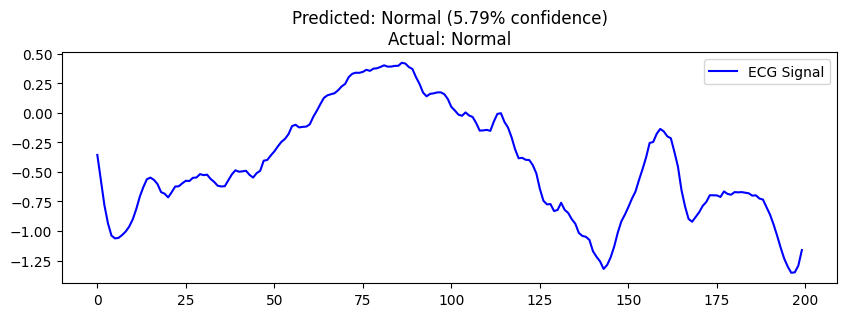

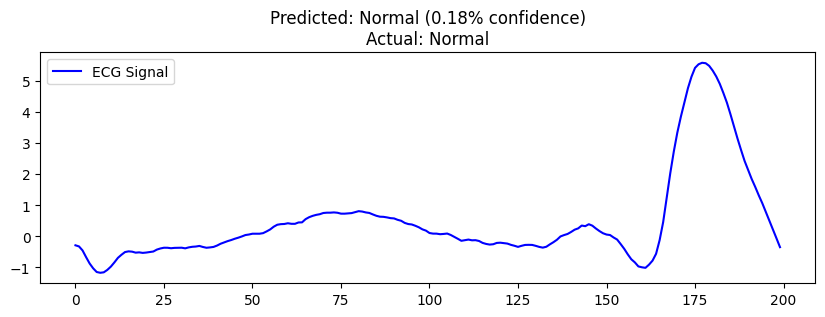

Mini-batch Accuracy on 10 samples: 9/10 (90.0%)


In [ ]:

# 🧪 MODEL TESTING + VERIFICATION (to check if .keras model predicts correctly)


from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
import joblib

# Load saved model and scaler
model = load_model("ecg_cnn_model.keras")
scaler = joblib.load("scaler.pkl")
class_names = joblib.load("class_names.pkl")

print("✅ Model and scaler loaded successfully.")

# Pick some random test samples
num_samples = 10
indices = np.random.choice(len(X_test), num_samples, replace=False)
sample_signals = X_test[indices]
sample_labels = y_test[indices]

# Predict probabilities
pred_probs = model.predict(sample_signals)
pred_classes = (pred_probs > 0.5).astype(int).flatten()

# Display results
for i in range(num_samples):
    plt.figure(figsize=(10,3))
    plt.plot(sample_signals[i].flatten(), color='blue', label='ECG Signal')
    plt.title(f"Predicted: {class_names[pred_classes[i]]} "
              f"({pred_probs[i][0]*100:.2f}% confidence)\n"
              f"Actual: {class_names[int(sample_labels[i])]}")
    plt.legend()
    plt.show()

# Calculate and print accuracy just for these few samples
correct = np.sum(pred_classes == sample_labels)
print(f"Mini-batch Accuracy on {num_samples} samples: {correct}/{num_samples} "
      f"({correct/num_samples*100:.1f}%)")


## XAI(SHAP)


Quantifies contribution of each input feature (ECG time point). Explains model predictions numerically.

Background shape: (20, 200, 1)
Test sample shape: (1, 200, 1)


/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer_4
Received: inputs=['Tensor(shape=(1, 200, 1))']
  warnings.warn(msg)
/usr/local/lib/python3.12/dist-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: input_layer_4
Received: inputs=['Tensor(shape=(50, 200, 1))']
  warnings.warn(msg)


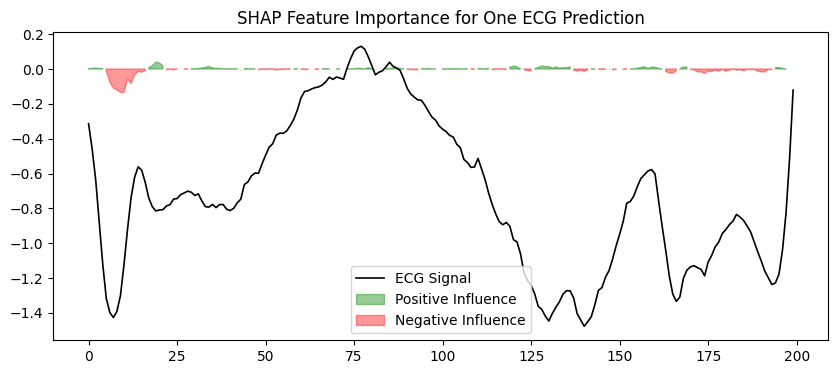

In [ ]:

# 🧩 FIXED SHAP EXPLANATION FOR ONE ECG SAMPLE

import shap

# Pick 20 background samples and 1 test sample
background = X_train[np.random.choice(X_train.shape[0], 20, replace=False)]
test_sample = X_test[0:1]

# Ensure correct shape (samples, time_steps, channels)
print("Background shape:", background.shape)
print("Test sample shape:", test_sample.shape)

# Create explainer using GradientExplainer (more stable for 1D CNNs)
explainer = shap.GradientExplainer(model, background)
shap_values = explainer.shap_values(test_sample)

# For binary classification, shap_values is a list with 1 array
if isinstance(shap_values, list):
    shap_vals = shap_values[0]
else:
    shap_vals = shap_values

# Flatten both arrays for plotting
signal = test_sample.flatten()
shap_curve = shap_vals.flatten()

plt.figure(figsize=(10, 4))
plt.plot(signal, label='ECG Signal', color='black', linewidth=1.2)
plt.fill_between(range(len(signal)), 0, shap_curve,
                 where=shap_curve > 0, color='green', alpha=0.4, label='Positive Influence')
plt.fill_between(range(len(signal)), 0, shap_curve,
                 where=shap_curve < 0, color='red', alpha=0.4, label='Negative Influence')
plt.title("SHAP Feature Importance for One ECG Prediction")
plt.legend()
plt.show()


In [ ]:
# Get top 10 influential time indices
top_indices = np.argsort(np.abs(shap_curve))[-10:][::-1]
print("Top 10 most influential ECG points:", top_indices)
print("Their SHAP values:", shap_curve[top_indices])

Top 10 most influential ECG points: [10  9  8  7 12  6 11 19 20 13]
Their SHAP values: [-0.1349526  -0.13398491 -0.11954891 -0.10905691 -0.08340403 -0.07410546
 -0.05694834  0.03995333  0.03551298 -0.0350966 ]


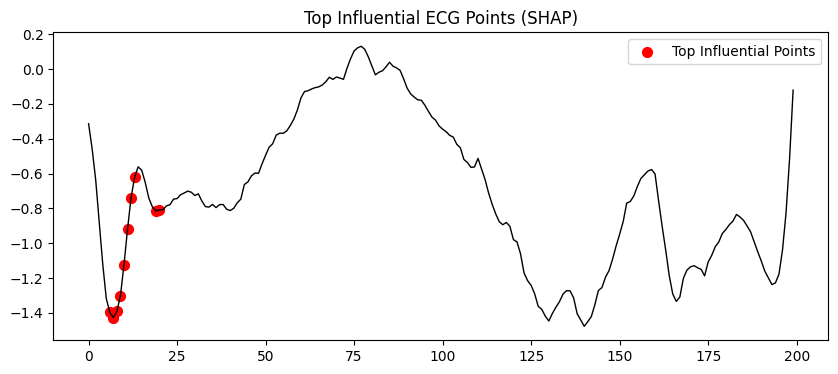

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(signal, color='black', linewidth=1)
plt.scatter(top_indices, signal[top_indices], color='red', s=50, label='Top Influential Points')
plt.title("Top Influential ECG Points (SHAP)")
plt.legend()
plt.show()

P_wave importance: 0.020657
QRS_complex importance: 0.002279
T_wave importance: 0.008182


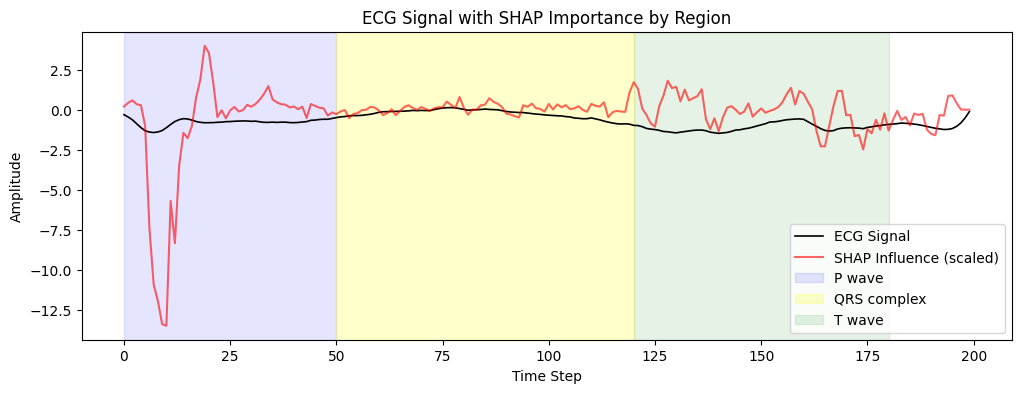

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define approximate ECG wave regions
regions = {
    "P_wave": (0, 50),
    "QRS_complex": (50, 120),
    "T_wave": (120, 180)
}

# Compute average |SHAP| importance per region
region_importance = {}
for region, (start, end) in regions.items():
    mean_val = np.mean(np.abs(shap_curve[start:end]))
    region_importance[region] = mean_val

# Display results
for region, imp in region_importance.items():
    print(f"{region} importance: {imp:.6f}")

# Plot signal with highlighted regions and SHAP overlay
plt.figure(figsize=(12, 4))
plt.plot(signal, color='black', linewidth=1.2, label='ECG Signal')
plt.plot(shap_curve * 100, color='red', alpha=0.6, label='SHAP Influence (scaled)')
plt.axvspan(*regions["P_wave"], color='blue', alpha=0.1, label='P wave')
plt.axvspan(*regions["QRS_complex"], color='yellow', alpha=0.2, label='QRS complex')
plt.axvspan(*regions["T_wave"], color='green', alpha=0.1, label='T wave')
plt.legend()
plt.title("ECG Signal with SHAP Importance by Region")
plt.xlabel("Time Step")
plt.ylabel("Amplitude")
plt.show()

An ECG signal shows the heart’s electrical activity during each beat:

1. **P wave:** Small bump showing atrial contraction (upper chambers pumping blood).

2. **QRS complex:** Tall sharp spike showing ventricular contraction (main pumping action).

3. **T wave:** Rounded bump showing the heart’s recovery or relaxation phase.

When SHAP highlights any of these regions, it means the model is focusing on that part of the heartbeat to make its prediction.

----
The black line represents the ECG signal, while the red line shows the SHAP influence (how strongly each part affected the model’s decision).
The QRS complex region is the most important part — that’s where your model focuses most when making its prediction.
This makes perfect sense medically, since the QRS complex represents the main heartbeat contraction, where most arrhythmia patterns appear.

## XAI(Saliency Maps)

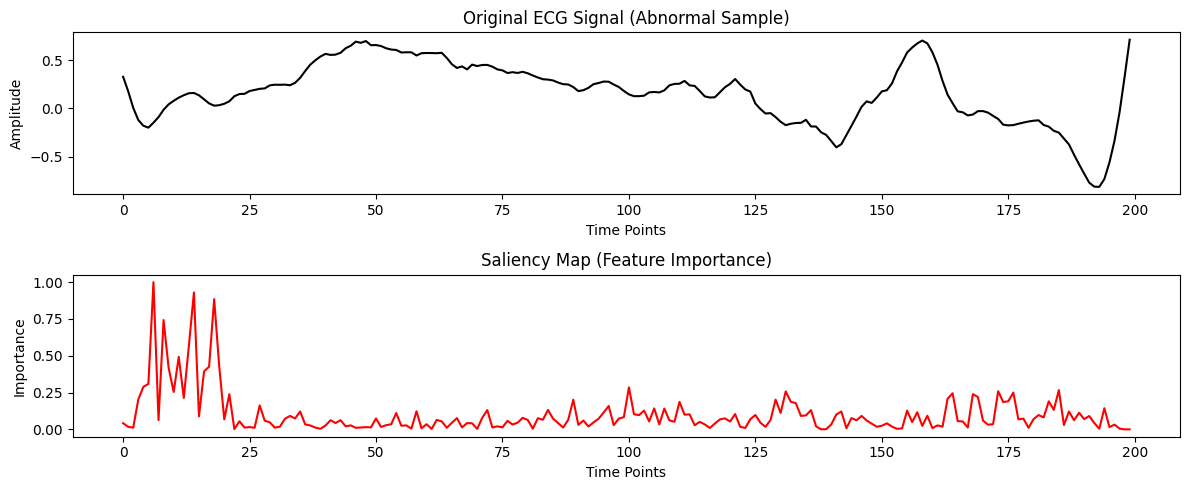

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Load the trained Keras model
model = load_model("ecg_cnn_model.keras")

# Use an abnormal sample from the test set (ensure X_test and y_test are available)
# Assuming X_test and y_test are already loaded and preprocessed (scaled and reshaped)
ab_idx = np.where(y_test == 1)[0]
if len(ab_idx) == 0:
    raise RuntimeError("No abnormal samples in X_test. Cannot generate saliency map.")
i = ab_idx[0]
ecg_sample = X_test[i:i+1] # Keep batch dimension for prediction

# Convert to TensorFlow tensor and ensure it's float32
ecg_tensor = tf.constant(ecg_sample, dtype=tf.float32)

# Compute Saliency Map
with tf.GradientTape() as tape:
    tape.watch(ecg_tensor)
    predictions = model(ecg_tensor)
    # For binary classification with sigmoid, we want the gradient of the predicted probability
    # with respect to the input. We can use the output directly.
    loss = predictions[0][0] # Assuming the output is a single probability for the positive class

# Get the gradients of the output with respect to the input tensor
gradients = tape.gradient(loss, ecg_tensor)

# Get the absolute values of the gradients and squeeze to remove batch and channel dimensions
saliency = tf.abs(gradients).numpy().squeeze()

# Normalize saliency map for better visualization
saliency = (saliency - saliency.min()) / (saliency.max() - saliency.min())

# Plot original ECG signal and saliency map
plt.figure(figsize=(12, 5))

plt.subplot(2, 1, 1)
plt.plot(ecg_sample.squeeze(), color='black')
plt.title('Original ECG Signal (Abnormal Sample)')
plt.xlabel('Time Points')
plt.ylabel('Amplitude')

plt.subplot(2, 1, 2)
plt.plot(saliency, color='red')
plt.title('Saliency Map (Feature Importance)')
plt.xlabel('Time Points')
plt.ylabel('Importance')

plt.tight_layout()
plt.show()

In this abnormal sample, the highest peaks in the saliency map appear near the beginning (around the P and QRS regions) and again toward the end (T-wave region).
This indicates that the model is paying closer attention to sharp changes in heart activity, which are typical markers of abnormal ECG patterns.

In [ ]:
# ✅ Save the trained autoencoder for Streamlit explainability
autoencoder.save("autoencoder_model.keras")
print("✅ Autoencoder model saved as autoencoder_model.keras")


✅ Autoencoder model saved as autoencoder_model.keras
